<a href="https://colab.research.google.com/github/fvrat/cough-detector/blob/main/GXBOOST_Cough_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Validation Accuracy: 0.9743
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2398
         1.0       0.96      0.94      0.95       798

    accuracy                           0.97      3196
   macro avg       0.97      0.96      0.97      3196
weighted avg       0.97      0.97      0.97      3196

Confusion Matrix:
 [[2364   34]
 [  48  750]]

📊 Test Accuracy: 0.9754
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4816
         1.0       0.95      0.95      0.95      1576

    accuracy                           0.98      6392
   macro avg       0.97      0.97      0.97      6392
weighted avg       0.98      0.98      0.98      6392

Confusion Matrix:
 [[4736   80]
 [  77 1499]]


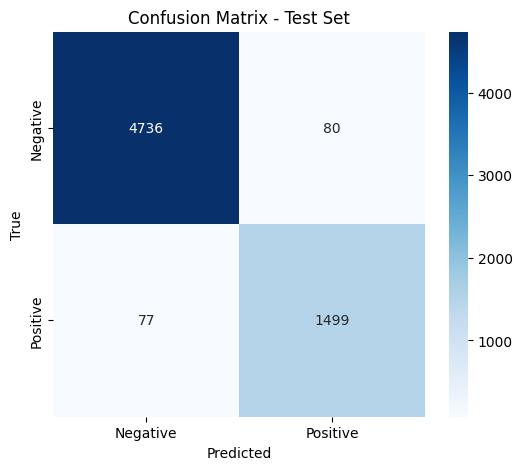

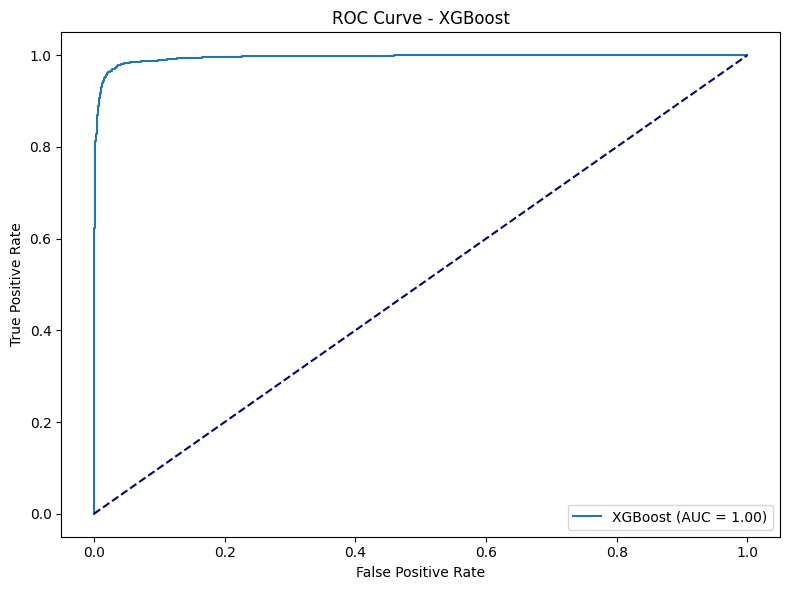

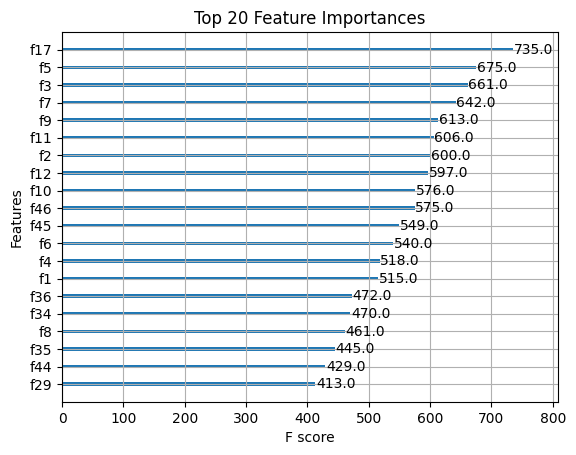

['xgboost_cough_model.pkl']

In [ ]:
# ----------------------------------
# Step 1: Import Libraries
# ----------------------------------
import numpy as np
import glob
import librosa
import xgboost as xgb
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# ----------------------------------
# Step 2: Dataset Paths
# ----------------------------------
extract_path = '/content/drive/MyDrive/Colab Notebooks/public_dataset/'
npz_files = glob.glob(f"{extract_path}/**/*.npz", recursive=True)

# ----------------------------------
# Step 3: Feature Extraction
# ----------------------------------
def load_and_process_data(npz_files):
    audio_features_list = []
    imu_features_list = []
    labels_list = []

    def extract_audio_features(audio_segment, sr=16000):
        mfccs = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=13), axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_segment, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio_segment, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_segment, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment))
        rms_energy = np.mean(librosa.feature.rms(y=audio_segment))
        return np.concatenate([mfccs, [spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate, rms_energy]])

    def extract_imu_features(imu_segment):
        features = []
        for i in range(imu_segment.shape[1]):
            axis_data = imu_segment[:, i]
            features.extend([
                np.mean(axis_data),
                np.std(axis_data),
                np.min(axis_data),
                np.max(axis_data),
                np.median(axis_data)
            ])
        return np.array(features)

    for npz_file in npz_files:
        data = np.load(npz_file)
        audio_data = data["audio_data"]
        imu_data = data["imu_data"]
        labels = data["labels"]

        for i in range(audio_data.shape[0]):
            audio_features = extract_audio_features(audio_data[i, :, 0])
            imu_features = extract_imu_features(imu_data[i, :, :])
            audio_features_list.append(audio_features)
            imu_features_list.append(imu_features)
            labels_list.append(labels[i])

    return np.array(audio_features_list), np.array(imu_features_list), np.array(labels_list)

# ----------------------------------
# Step 4: Process Dataset
# ----------------------------------
audio_features_array, imu_features_array, labels_array = load_and_process_data(npz_files)
X_combined = np.concatenate([audio_features_array, imu_features_array], axis=1)
y = labels_array

# ----------------------------------
# Step 5: Train/Val/Test Split
# ----------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

# ----------------------------------
# Step 6: Handle Class Imbalance
# ----------------------------------
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# ----------------------------------
# Step 7: Hyperparameter Tuning
# ----------------------------------
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

xgb_clf = xgb.XGBClassifier(
    eval_metric='mlogloss',
    scale_pos_weight=scale_weight,
    use_label_encoder=False
)

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
model = random_search.best_estimator_

# ----------------------------------
# Step 8: Threshold Tuning
# ----------------------------------
val_probs = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# ----------------------------------
# Step 9: Evaluate Function
# ----------------------------------
def evaluate(model, X, y_true, title="Validation"):
    probs = model.predict_proba(X)[:, 1]
    y_pred = (probs > optimal_threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n📊 {title} Accuracy: {accuracy:.4f}")
    print(report)
    print("Confusion Matrix:\n", cm)
    return y_true, y_pred, cm, probs

# ----------------------------------
# Step 10: Run Evaluation
# ----------------------------------
_, _, val_cm, _ = evaluate(model, X_val, y_val, title="Validation")
y_test_true, y_test_pred, test_cm, y_test_proba = evaluate(model, X_test, y_test, title="Test")

# ----------------------------------
# Step 11: Confusion Matrix Plot
# ----------------------------------
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(test_cm, "Test Set")

# ----------------------------------
# Step 12: ROC Curve
# ----------------------------------
fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.title('ROC Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# ----------------------------------
# Step 13: Feature Importance
# ----------------------------------
xgb.plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()

import joblib

# Save the trained XGBoost model
joblib.dump(model, "xgboost_cough_model.pkl")


In [ ]:
# Save the trained model to JSON format
json_model_path = '/content/drive/MyDrive/Colab Notebooks/xgboost_model.json'
model.get_booster().save_model(json_model_path)

print(f" Model saved to: {json_model_path}")

✅ Model saved to: /content/drive/MyDrive/Colab Notebooks/xgboost_model.json


In [ ]:
import os
import numpy as np
import glob

# Path to the dataset root folder containing patient subfolders
dataset_root = "/content/drive/MyDrive/Colab Notebooks/public_dataset/public_dataset"

# Get a list of all patient folders
patient_folders = [f.path for f in os.scandir(dataset_root) if f.is_dir()]

# Dictionary to store patient cough counts
cough_stats = {}

for patient_folder in patient_folders:
    patient_id = os.path.basename(patient_folder)
    npz_files = glob.glob(os.path.join(patient_folder, "*.npz"))

    total_segments = 0
    cough_count = 0

    for file in npz_files:
        data = np.load(file)
        labels = data["labels"]
        total_segments += len(labels)
        cough_count += np.sum(labels == 1)

    cough_stats[patient_id] = {
        "total_segments": total_segments,
        "cough_segments": cough_count
    }

# Print results
for patient, stats in cough_stats.items():
    print(f"🧍 Patient: {patient}")
    print(f"   Total Segments: {stats['total_segments']}")
    print(f"   Cough Segments: {stats['cough_segments']}\n")


🧍 Patient: 14287
   Total Segments: 2040
   Cough Segments: 510

🧍 Patient: 14342
   Total Segments: 1720
   Cough Segments: 430

🧍 Patient: 14547
   Total Segments: 2408
   Cough Segments: 602

🧍 Patient: 20794
   Total Segments: 1336
   Cough Segments: 334

🧍 Patient: 38936
   Total Segments: 2704
   Cough Segments: 676

🧍 Patient: 47779
   Total Segments: 2560
   Cough Segments: 640

🧍 Patient: 49661
   Total Segments: 2008
   Cough Segments: 502

🧍 Patient: 55502
   Total Segments: 3336
   Cough Segments: 834

🧍 Patient: 76918
   Total Segments: 2680
   Cough Segments: 670

🧍 Patient: 84479
   Total Segments: 2240
   Cough Segments: 560

🧍 Patient: 86463
   Total Segments: 2136
   Cough Segments: 534

🧍 Patient: 87369
   Total Segments: 2096
   Cough Segments: 524

🧍 Patient: 87447
   Total Segments: 2328
   Cough Segments: 582

🧍 Patient: 97706
   Total Segments: 2368
   Cough Segments: 592

